In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
df['Gender_Encoded'] = df['Gender'].map({'Female': 0, 'Male': 1})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   Gender          566 non-null    object 
 2   TB              566 non-null    float64
 3   DB              566 non-null    float64
 4   Alkphos         566 non-null    int64  
 5   Sgpt            566 non-null    int64  
 6   Sgot            566 non-null    int64  
 7   TP              566 non-null    float64
 8   ALB             566 non-null    float64
 9   A/G Ratio       566 non-null    float64
 10  Selector        566 non-null    int64  
 11  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 53.2+ KB


In [5]:
df = df.drop(columns=['Gender'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   TB              566 non-null    float64
 2   DB              566 non-null    float64
 3   Alkphos         566 non-null    int64  
 4   Sgpt            566 non-null    int64  
 5   Sgot            566 non-null    int64  
 6   TP              566 non-null    float64
 7   ALB             566 non-null    float64
 8   A/G Ratio       566 non-null    float64
 9   Selector        566 non-null    int64  
 10  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 48.8 KB


In [7]:
X = df.drop(columns=['Selector'])
y = df["Selector"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import pandas as pd

# 1. Tentukan kolom mana yang mau di-scale (Semua KECUALI 'Gender')
# Kita ambil nama semua kolom, lalu buang 'Gender' dari list
cols_to_scale = [col for col in X_train.columns if col != 'Gender']

# 2. Siapkan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num',          RobustScaler(),    cols_to_scale)
    ],
    remainder='passthrough',  # PENTING: Kolom sisa ('Gender') dibiarkan lewat tanpa diubah
    verbose_feature_names_out=False # Agar nama kolom tidak berubah jadi aneh (misal: num__Age)
).set_output(transform="pandas") # FITUR BARU: Output langsung jadi DataFrame (bukan array)

# 3. Terapkan pada Data
# fit_transform pada Train
X_train_scaled = preprocessor.fit_transform(X_train)

# transform saja pada Test
X_test_scaled = preprocessor.transform(X_test)

# Cek hasil
print("Preview Data (Gender tidak berubah, yang lain berubah):")
print(X_train_scaled.head())

Preview Data (Gender tidak berubah, yang lain berubah):
          Age      TB   DB   Alkphos      Sgpt      Sgot        TP       ALB  \
107  0.192308  3.0000  2.7  3.713115  4.082759  4.179487 -0.641509 -0.727273   
381 -0.269231 -0.1250 -0.1  0.000000 -0.220690  0.162393  0.415094  0.545455   
182  0.153846  0.6250  0.3  0.008197  0.413793 -0.145299 -0.641509 -0.090909   
296 -0.576923 -0.1250 -0.1 -0.409836 -0.220690 -0.316239  1.018868  1.272727   
277 -0.846154  0.0625  0.2 -0.139344  0.110345  0.008547  0.867925  1.090909   

     A/G Ratio  Gender_Encoded  
107     -0.675             0.0  
381      0.150             0.0  
182      0.400             0.0  
296      0.900            -1.0  
277      0.650             0.0  


In [ ]:
n_features_to_select = 8  # ganti jika mau

base_estimator_rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rfe_rf = RFE(
    estimator=base_estimator_rf,
    n_features_to_select=n_features_to_select,
    step=1
)

rfe_rf.fit(X_train_scaled, y_train)

selected_mask_rf = rfe_rf.support_
selected_features_rf = X_train_scaled.columns[selected_mask_rf]

print("Fitur terpilih (RF + RFE")
for f in selected_features_rf:
    print("-", f)

Fitur terpilih (RF + RFE + SMOTE-Tomek):
- Age
- TB
- DB
- Alkphos
- Sgpt
- Sgot
- TP
- ALB


In [11]:
X_train_selected = X_train_scaled[selected_features_rf]
X_test_selected = X_test_scaled[selected_features_rf]

In [12]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_res_clean, y_res_clean = smote_enn.fit_resample(X_train_selected, y_train)

In [13]:
mlp = MLPClassifier(
    max_iter=300,
    random_state=42,
    early_stopping=True
)

param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64)],
    "activation": ["tanh", "relu"],
    "solver": ["adam", "sgd"],
    "alpha": [1e-4, 1e-3, 1e-2],
    "learning_rate_init": [0.001, 0.01]
}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=10,
    scoring="roc_auc",   # gunakan ROC AUC
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_res_clean, y_res_clean)

print("Best ROC AUC (CV):", grid_search.best_score_)
print("Best params:", grid_search.best_params_)
best_mlp = grid_search.best_estimator_

# ROC AUC di test set (binary)
y_proba = best_mlp.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", test_roc_auc)


Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), lea

In [15]:
from sklearn.metrics import classification_report, roc_auc_score

# Prediksi label di test set
y_pred = best_mlp.predict(X_test_selected)

# Classification report (precision, recall, f1, support)
print(classification_report(y_test, y_pred))

# Kalau mau sekalian ROC AUC (binary)
y_proba = best_mlp.predict_proba(X_test_selected)[:, 1]
roc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", roc)


              precision    recall  f1-score   support

           0       0.53      0.94      0.68        33
           1       0.96      0.67      0.79        81

    accuracy                           0.75       114
   macro avg       0.75      0.80      0.73       114
weighted avg       0.84      0.75      0.76       114

Test ROC AUC: 0.8477366255144032


Confusion matrix:
 [[31  2]
 [27 54]]


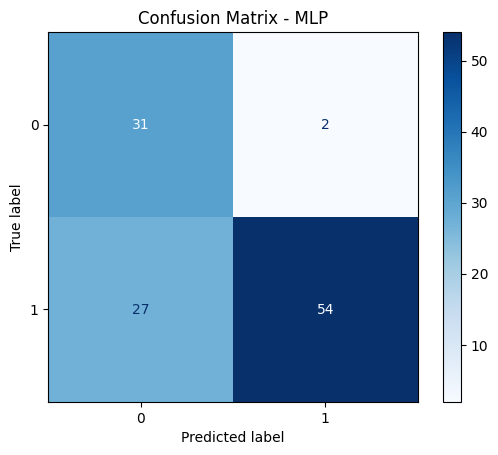

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - MLP")
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Base estimator (weak learner)
base_tree = DecisionTreeClassifier(
    max_depth=1,          # stump klasik AdaBoost
    random_state=42
)

ada = AdaBoostClassifier(
    estimator=base_tree,  # atau base_estimator=base_tree untuk versi sklearn lama
    random_state=42
)

param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.5, 1.0],
    "estimator__max_depth": [1, 2, 3]  # tuning depth tree
}

grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=10,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

# pakai data train hasil balancing/cleaning
grid_search.fit(X_res_clean, y_res_clean)

print("Best ROC AUC (CV):", grid_search.best_score_)
print("Best params:", grid_search.best_params_)
best_ada = grid_search.best_estimator_

# evaluasi di test set (tanpa resampling!)
y_proba = best_ada.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", test_roc_auc)


Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END estimator__max_depth=1, learning_rate=

In [18]:
from sklearn.metrics import classification_report, roc_auc_score

# Prediksi label di test set
y_pred = best_ada.predict(X_test_selected)

# Classification report (precision, recall, f1, support)
print(classification_report(y_test, y_pred))

# Kalau mau sekalian ROC AUC (binary)
y_proba = best_ada.predict_proba(X_test_selected)[:, 1]
roc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", roc)


              precision    recall  f1-score   support

           0       0.50      0.73      0.59        33
           1       0.86      0.70      0.78        81

    accuracy                           0.71       114
   macro avg       0.68      0.72      0.68       114
weighted avg       0.76      0.71      0.72       114

Test ROC AUC: 0.8237934904601572


Confusion matrix:
 [[24  9]
 [24 57]]


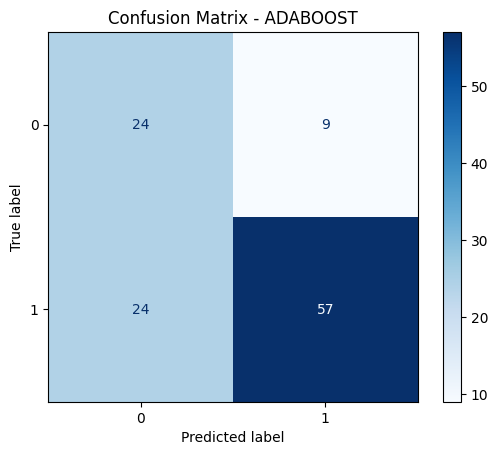

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - ADABOOST")
plt.show()

In [20]:
# model dasar
cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=0,          # biar nggak spam log saat GridSearch
    random_state=42
)

param_grid = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [200, 400, 800],
    "l2_leaf_reg": [1, 3, 5]
}


In [ ]:
grid_search = GridSearchCV(
    estimator=cat,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_res_clean, y_res_clean)

print("Best ROC AUC (CV):", grid_search.best_score_)
print("Best params:", grid_search.best_params_)

best_cat = grid_search.best_estimator_


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_

In [22]:
# prediksi probabilitas untuk ROC AUC
y_proba = best_cat.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", test_roc_auc)

# prediksi kelas + classification report
y_pred = best_cat.predict(X_test_selected)
print(classification_report(y_test, y_pred))


Test ROC AUC: 0.8256640478862701
              precision    recall  f1-score   support

           0       0.53      0.85      0.65        33
           1       0.92      0.69      0.79        81

    accuracy                           0.74       114
   macro avg       0.72      0.77      0.72       114
weighted avg       0.81      0.74      0.75       114



Confusion matrix:
 [[28  5]
 [25 56]]


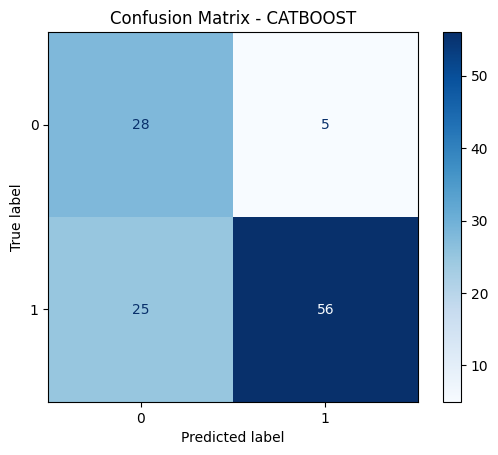

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - CATBOOST")
plt.show()